# Book Recommendation System (Modeling)


Now, it's time for us to to develop recommendation systems. In this notebook, the recommendation systems developed based on several methods: 
1. Basic Recommender
2. Content-based Filtering
3. Collaborative Filtering

In the end, I will compare the result given by the recommendation systems and explore strengths and weakness of each model.

In [4]:
## Import Libraries
# !conda install -c conda-forge scikit-surprise

In [7]:
!pip3 install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for content based filtering
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

#for collaborative filtering
import os
import math
import random

from surprise import accuracy, Reader, Dataset, dump
from surprise import NormalPredictor, KNNBasic, SVD, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV

## Import Dataset

In [9]:
pd.options.display.float_format = '{:.2f}'.format
r = pd.read_csv('data/ratings.csv')
b = pd.read_csv('data/books_cleaned.csv')

## 1. Simple Recommendation

## Motivation for Weighted Rating

A simple way to recommend books is by ranking them based on:
- **`average_rating`** (how good people think the book is), or
- **`ratings_count`** (how many people rated the book – a measure of popularity)

However, based on our earlier analysis, we noticed:

1. Some books with **high average ratings** have **very few ratings** — they may not be reliable.
2. Some books with **many ratings** (popular) have only **average or low scores**.

Because of this, it's not ideal to use just one of these metrics on its own.

To solve this, we will create a **weighted rating** that combines both `average_rating` and `ratings_count`. This gives us a more balanced and fair way to rank books.


### a. Recommendation based on Weighted Average of Rating and Popularity

## Why We Need a Better Scoring System

One of the easiest ways to recommend books is by ranking them using:
- **`average_rating`** (how good the book is), or
- **`ratings_count`** (how popular it is)

But during the EDA, we saw two issues:
1. Some books with **high average ratings** have **very few ratings** — they may not be trustworthy.
2. Some books with **many ratings** have **average or even low scores**.

So, to get a better measure, we need a **new score** that combines both `average_rating` and `ratings_count`.

### IMDB-Style Weighted Rating

To do this, we’ll use a scoring method similar to what IMDB uses for its **Top 250 Movies** list.

The **new rating score** is calculated using this formula:

![New Rating Formula](img/new_rating_score.png "New Rating Score")


where:<br>
v = number of ratings (`ratings_count`)<br>
m = minimum `ratings_count` required to be recommended<br>
R = average of ratings (`average_rating`) <br>
C = the mean ratings for all books

## Setting the Minimum Votes Threshold (m)

To apply the weighted rating formula, we need to set a value for **`m`**,  
which is the **minimum number of ratings** a book must have to be included in the recommendation list.

For this simple recommender system, we’ll use the **95th percentile** as our cutoff.  
This means a book must have **more ratings than 95%** of all books in the dataset.

In our case, that turns out to be around **2,100 ratings**.  
So, only books with **at least 2,100 ratings** will be considered in the final recommendation chart.


In [10]:
def simple_recommender(books, n=5):
    v = books['ratings_count']
    m = books['ratings_count'].quantile(0.95)
    R = books['average_rating']
    C = books['average_rating'].median()
    score = (v/(v+m) * R) + (m/(m+v) * C)   
    books['score'] = score
    
    qualified  = books.sort_values('score', ascending=False)
    return qualified[['book_id', 'title', 'authors', 'average_rating', 'ratings_count','score']].head(n)

In [11]:
simple_recommender(b)

,book_id,title,authors,average_rating,ratings_count,score
21,25,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,4.61,1746574,4.56
23,27,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1678823,4.49
15,18,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.53,1832823,4.49
20,24,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,4.53,1753043,4.48
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.44,4602479,4.43


### b. Evaluation

## Limitations of the Simple Recommender

The current system gives **general recommendations** to all users based only on:
- **Popularity** (`ratings_count`)
- **Average rating**

However, this approach has some **limitations**:
- It shows the **same suggestions to everyone**, no matter what their


## 2. Content Based Recommendation System

### a. Recommendation based on Cosine Similarity

## Building a Content-Based Recommender

To make our recommendations more **personalized**, we’ll use **cosine similarity** to compare books based on their content.

### Steps:

1. **Create a new column** that combines useful information from each book —  
   including **authors**, **title**, **genres**, and **description**.

2. Use **`TFIDFVectorizer`** to convert this text data into **numerical vectors**.

3. Compute the **cosine similarity scores** between all books.

4. Take a user's **favorite book as input**, and find books that are **most similar** to it.

5. **Recommend** the top similar books to the user.

> 💡 Since we’re using `TFIDFVectorizer`, the dot product gives us the cosine similarity directly.  
> That’s why we’ll use `sklearn`'s `linear_kernel` — it’s faster than `cosine_similarity`.


In [12]:
def content(books):
    books['content'] = (pd.Series(books[['authors', 'title', 'genres', 'description']]
                                  .fillna('')
                                  .values.tolist()
                                  ).str.join(' '))

    tf_content = TfidfVectorizer(analyzer='word', ngram_range=(
        1, 2), min_df=1, stop_words='english')
    tfidf_matrix = tf_content.fit_transform(books['content'])
    cosine = linear_kernel(tfidf_matrix, tfidf_matrix)
    index = pd.Series(books.index, index=books['title'])

    return cosine, index

In [13]:
def content_recommendation(books, title, n=5):
    cosine_sim, indices = content(books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n + 1]
    book_indices = [i[0] for i in sim_scores]
    return books[['book_id', 'title', 'authors', 'average_rating', 'ratings_count']].iloc[book_indices]

In [14]:
content_recommendation(b, '1984')

,book_id,title,authors,average_rating,ratings_count
795,846,Animal Farm / 1984,George Orwell,4.26,116197
2048,2187,We,Yevgeny Zamyatin,3.95,40020
3670,4004,Homage to Catalonia,George Orwell,4.14,22227
6857,8056,"1Q84 #1-2 (1Q84, #1-2)",Haruki Murakami,4.07,8342
4915,5510,The Far Side Gallery,Gary Larson,4.42,20022


Notice that the system recommends a book with average_rating (3.95) lower than average and book with low `ratings_count` (8342). We will try to improve our recommendation by adding popularity-rating filter.

### b. Content Based + Popularity-Rating Filter

The mechanism to remove books with low ratings has been added on top of the content based filtering. This system will return books that are similar to your input, are popular and have high ratings. However, in this filter, our cutoff will be the quantile 75. In order for a book to appear in the recommendation, it must be ranked in top 25 similar and receive at least 75% weight score of the other books on the list (around 800 ratings).

In [15]:
def improved_recommendation(books, title, n=5):
    cosine_sim, indices = content(books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    book_indices = [i[0] for i in sim_scores]
    books2 = books.iloc[book_indices][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]

    v = books2['ratings_count']
    m = books2['ratings_count'].quantile(0.75) #here the minimum rating is quantile 75
    R = books2['average_rating']
    C = books2['average_rating'].median()
    books2['new_score'] = (v/(v+m) * R) + (m/(m+v) * C)

    high_rating = books2[books2['ratings_count'] >= m]
    high_rating = high_rating.sort_values('new_score', ascending=False)

    return high_rating[['book_id', 'title', 'authors', 'average_rating', 'ratings_count','new_score']].head(n)

In [16]:
improved_recommendation(b, '1984')

,book_id,title,authors,average_rating,ratings_count,new_score
795,846,Animal Farm / 1984,George Orwell,4.26,116197,4.20
759,809,Brave New World / Brave New World Revisited,Aldous Huxley,4.16,108124,4.13
1044,1120,Aesop's Fables,Aesop,4.05,88508,4.05
8316,2375,"Tinker, Tailor, Soldier, Spy",John le Carré,4.04,40871,4.04
604,649,1Q84,Haruki Murakami,3.89,125195,3.93


### c. Evaluation

This method is suitable for people who are looking for similar books, but this system can not capture tastes and provide recommendations across genres. Therefore, we will try to build a recommendation system using Collaborative filtering.

## 3. Collaborative Filtering

This system suggests book to users based on past reading history and collaboration of other users' preferences. This recommender systems provides personalized recommendation. In this notebook, I will use [Surprise](https://surpriselib.com/) library to make the recommendation system. Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. I will try to fit into 4 model and evaluate by using RMSE value. The model I use:
1. **Normal Predictor**
2. **KNN** (Memory-based)
3. **SVD** (Model-based)

Since the calculation is taking to much memory, I dump the calculation file in order to reuse it for comparison. I will also test all the recommendation system to user 12874. This user is one of the user that give many ratings.

In [17]:
#to have reproducible experiments
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [18]:
#Load the full dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(r, reader)

In [19]:
#shuffle the ratings for unbiased result
all_ratings = data.raw_ratings
random.shuffle(all_ratings)

In [20]:
#split data into train and test data with the ratio 70:30
threshold = int(0.6 * len(all_ratings))
train_ratings = all_ratings[:threshold]
test_ratings = all_ratings[threshold:]

In [21]:
def book_read(user_id):
    '''Take user_id and return list of book that user has read'''
    books_list = list(b['book_id'])
    book_read_list = list(r['book_id'][r['user_id'] == user_id])
    return books_list, book_read_list

### a. Normal Predictor

Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

In [22]:
# prepare train data
data.raw_ratings = train_ratings

#select algorithm
npred = NormalPredictor()

In [23]:
%%time

#cross validation for train data
np_result = cross_validate(npred, data, measures=['RMSE'], cv=5, verbose=True, n_jobs=2)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3245  1.3239  1.3231  1.3249  1.3248  1.3242  0.0007  
Fit time          1.58    1.67    1.56    1.62    1.61    1.61    0.04    
Test time         4.28    3.66    3.93    3.98    3.04    3.78    0.42    
CPU times: total: 54 s
Wall time: 1min 4s


In order to make prediction on test data, we have to retrain whole train set first.

In [24]:
%%time
#retrain whole train test
trainset = data.build_full_trainset()
npred.fit(trainset)

# Compute RMSE on trainset (without fold)
np_train_pred = npred.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(np_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
np_test_pred = npred.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(np_test_pred)

Train RMSE:
RMSE: 1.3232
Test RMSE:
RMSE: 1.3233
CPU times: total: 46.2 s
Wall time: 48.5 s


In [25]:
# uncomment this code to dump the calculation result for future use
dump.dump('./models/dump_np', np_test_pred, npred)

Now we can get recommendation for user 12874

In [29]:
%%time

data.raw_ratings = all_ratings
npred.fit(data.build_full_trainset())

CPU times: total: 13.8 s
Wall time: 15.4 s


In [30]:
def get_recommendation_npred(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = npred.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [31]:
get_recommendation_npred(12874, 5)

,book_id,title,authors,average_rating,ratings_count
39,45,Life of Pi,Yann Martel,3.88,1003228
46,53,"Eragon (The Inheritance Cycle, #1)",Christopher Paolini,3.86,1104021
57,64,My Sister's Keeper,Jodi Picoult,4.06,863879
65,73,"The Host (The Host, #1)",Stephenie Meyer,3.84,749780
77,86,A Time to Kill,John Grisham,4.03,597775


### b. K-Nearest Neighbour

These are algorithms that are directly derived from a basic nearest neighbors approach.

In [32]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
sim_options = {"name": "cosine",
               "user_based": False}
knn = KNNBasic(sim_options=sim_options)

In [33]:
%%time

#cross validation for train data
knn_result = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=True, n_jobs = 1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8887  0.8910  0.8916  0.8910  0.8915  0.8908  0.0011  
Fit time          32.49   37.47   32.66   32.36   32.08   33.41   2.04    
Test time         53.37   42.95   51.78   42.27   51.52   48.38   4.76    
CPU times: total: 6min 49s
Wall time: 7min 18s


In [36]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
knn.fit(trainset)

# Compute RMSE on trainset (without fold)
knn_train_pred = knn.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(knn_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
knn_test_pred = knn.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(knn_test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Train RMSE:
RMSE: 0.8070
Test RMSE:
RMSE: 0.8866
CPU times: total: 6min 42s
Wall time: 6min 55s


In [37]:
# uncomment this code to dump the calculation result for future use
dump.dump('./models/dump_knn', knn_test_pred, knn)

Now we can get recommendation for user 12874

In [38]:
%%time

data.raw_ratings = all_ratings
knn.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 2min 4s
Wall time: 2min 7s


In [39]:
def get_recommendation_knn(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = knn.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [40]:
get_recommendation_knn(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
89,98,"The Girl Who Played with Fire (Millennium, #2)",Stieg Larsson,4.22,563994
103,114,Tuesdays with Morrie,Mitch Albom,4.06,556518
118,132,The Five People You Meet in Heaven,Mitch Albom,3.90,449501
126,140,The Girl Who Kicked the Hornet's Nest (Millenn...,Stieg Larsson,4.20,443951


### c. Singular Value Decomposition (SVD)

The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. SVD finds the latent factors associated with some matrix. SVD will decompose user-rating matrix into matrices that represents latent user-user features and item-item features.

In [41]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
svd = SVD(random_state=0)

In [42]:
%%time

#cross validation for train data
svd_result = cross_validate(svd, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8580  0.8594  0.8579  0.8574  0.8573  0.8580  0.0007  
Fit time          15.54   15.76   16.22   15.70   14.33   15.51   0.63    
Test time         5.33    5.62    5.18    5.29    4.58    5.20    0.34    
CPU times: total: 55.2 s
Wall time: 1min 22s


In [44]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
svd.fit(trainset)

# Compute RMSE on trainset (without fold)
svd_train_pred = svd.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svd_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svd_test_pred = svd.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svd_test_pred)

Train RMSE:
RMSE: 0.6449
Test RMSE:
RMSE: 0.8465
CPU times: total: 1min 24s
Wall time: 1min 29s


In [45]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_svd', svd_test_pred, svd)

Now we can get recommendation for user 12874

In [46]:
%%time

data.raw_ratings = all_ratings
svd.fit(data.build_full_trainset())

CPU times: total: 1min 10s
Wall time: 1min 11s


In [47]:
def get_recommendation_svd(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svd.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [48]:
get_recommendation_svd(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
194,215,Ready Player One,Ernest Cline,4.31,349423
226,250,Wonder,R.J. Palacio,4.43,228538
390,425,Go Ask Alice,Beatrice Sparks,3.77,196677
1698,1808,"Morning Star (Red Rising, #3)",Pierce Brown,4.50,47736


### e. Evaluation

In [49]:
#uncomment this code to load the dump file
np_test_pred, npred = dump.load('./models/dump_np')
knn_test_pred, knn = dump.load('./models/dump_knn')
svd_test_pred, svd = dump.load('./models/dump_svd')

In [51]:
#making the calculation reult into dataframe
df_np = pd.DataFrame(np_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_knn = pd.DataFrame(knn_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])  

#### Comparing Prediction Distribution

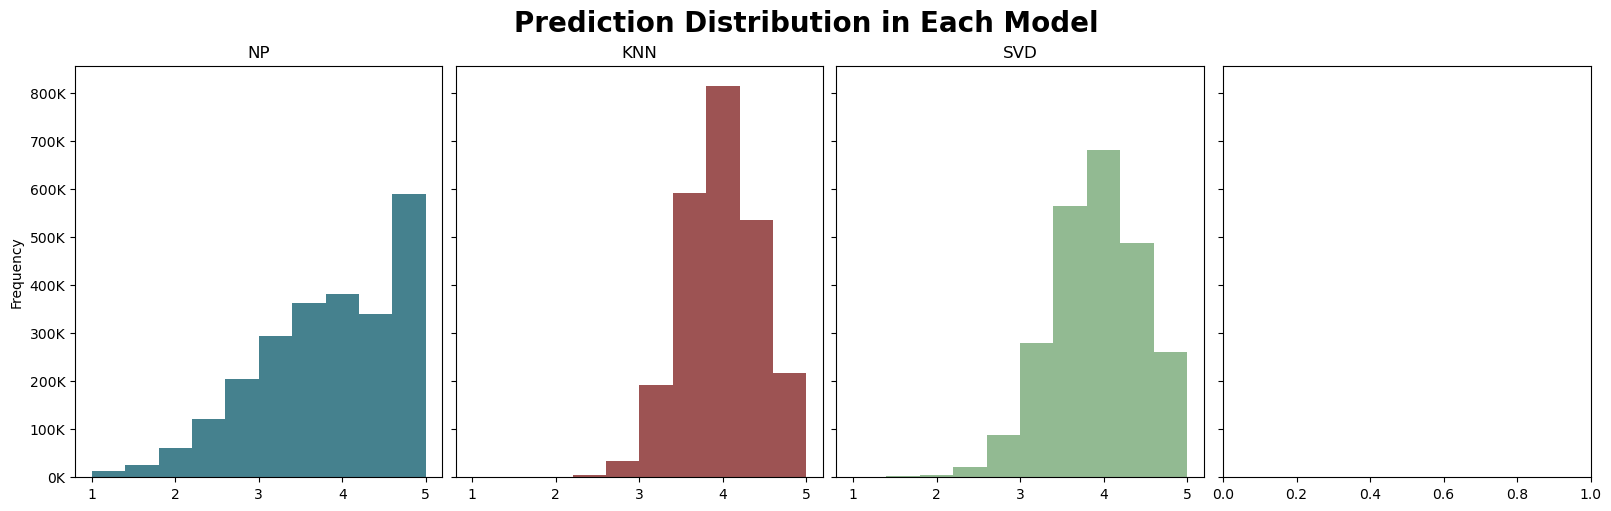

In [55]:
# Count the number of predictions for each rating value
figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(16, 5), sharey=True, constrained_layout=True)
df_np.est.plot(kind='hist', title='NP', ax=ax1, color='#45818E')
df_knn.est.plot(kind='hist', title='KNN', ax=ax2, color='#9D5353')
df_svd.est.plot(kind='hist', title='SVD', ax=ax3, color='#92BA92')
current_values = plt.gca().get_yticks() / 1000
plt.gca().set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in current_values])
plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=20)
plt.show()

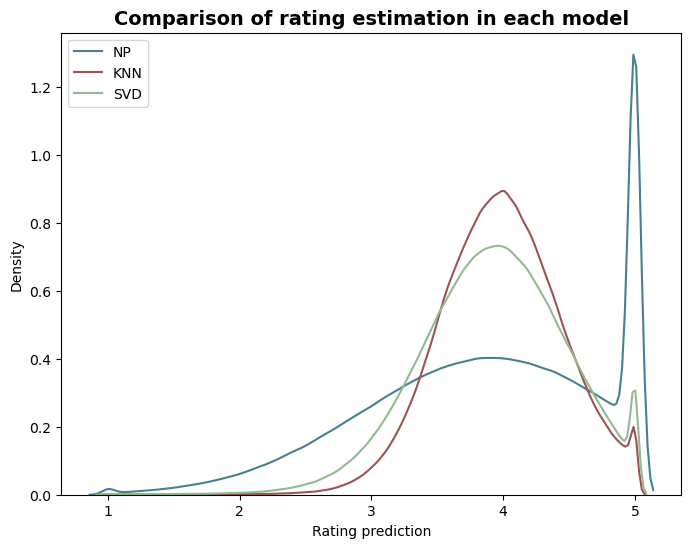

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_np['est'], shade=False, color='#45818E', label = 'NP', ax=ax)
sns.kdeplot(df_knn['est'], shade=False, color='#9D5353', label = 'KNN', ax=ax)
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in each model', weight='bold', fontsize=14)
plt.show()

As we can see, Normal Predictor model predicts higher ratings more often, meanwhile KNN predictions are concentrated around the mean. For SVD and SVD++, the ratings are more fairly distributed.

## Hyperparameter Tuning on Best Model

Based on our comparison, we choose SVD as the best model. SVD was chosen because it has a relatively low RMSE value, relatively short processing time and the memory used is not too large.<br>
To tune the hyperparameter, we can utilize grid search, an optimization technique that explores all possibilities of the provided hyperparameter options. The parameters that will be tuned are:
- n_epochs: the number of iterations of the SGD procedure
- lr_all: the learning rate for all parameters
- reg_all: the regularization term for all parameters

In [58]:
# prepare train data
data.raw_ratings = train_ratings

In [59]:
%%time

grid = {'n_epochs': [20, 30], 
        'lr_all': [.005, .001], 
        'reg_all': [0.02, 0.04]} 

gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=5, n_jobs=2)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.846952345095638
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.04}
CPU times: total: 4min 3s
Wall time: 16min 36s


In [60]:
#select best algorithm
svdtuned = gs.best_estimator['rmse']

In [61]:
%%time

#retrain whole train test (without fold)
trainset = data.build_full_trainset()
svdtuned.fit(trainset)

# Compute RMSE on trainset (without fold)
svdtuned_train_pred = svdtuned.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdtuned_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdtuned_test_pred = svdtuned.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdtuned_test_pred)

Train RMSE:
RMSE: 0.6533
Test RMSE:
RMSE: 0.8351
CPU times: total: 3min 9s
Wall time: 4min 43s


In [62]:
%%time

data.raw_ratings = all_ratings
svdtuned.fit(data.build_full_trainset())

CPU times: total: 2min 23s
Wall time: 2min 39s


In [63]:
def get_recommendation(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdtuned.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [64]:
get_recommendation(12874, 5)

,book_id,title,authors,average_rating,ratings_count
810,862,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77,73572
3353,3628,The Complete Calvin and Hobbes,Bill Watterson,4.82,28900
4977,5580,The Calvin and Hobbes Lazy Sunday Book,Bill Watterson,4.66,18641
6010,6902,Standing for Something: 10 Neglected Virtues T...,Gordon B. Hinckley,4.61,12708
6024,6920,The Indispensable Calvin and Hobbes,Bill Watterson,4.73,14597


In [65]:
# uncomment this code to dump the calculation result for future use
dump.dump('./models/dump_tuning', svdtuned_test_pred, svdtuned)

In [66]:
# uncomment this code to load the dump file
svd_test_pred, svd = dump.load('./models/dump_svd')
svdtuned_test_pred, svdtuned = dump.load('./models/dump_tuning')

In [67]:
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svdtuned = pd.DataFrame(svdtuned_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

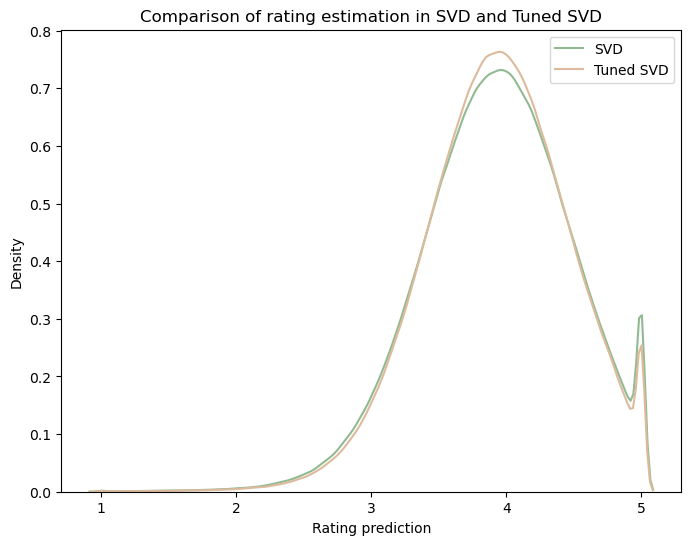

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdtuned['est'], shade=False, color='#DEBA9D', label = 'Tuned SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in SVD and Tuned SVD')
plt.show()

Rating prediction around the mean is higher in tuned SVD. This is probably as a result of higher `reg_all`, so the parameter are regularized.

## Conclusion

## Summary of Recommendation Models

### 1. Simple Recommender

This is a **basic model** that recommends books based on **popularity** (ratings count) and **average rating**.  
It gives the **same suggestions to everyone** and does not personalize results.

✅ Suitable for **new users** since it doesn’t rely on user history.  
❌ Not personalized — can’t adapt to individual preferences.

> 💡 *Cold-start problem*: This model **does not suffer** from it, since it doesn’t need any prior user data.

---

### 2. Content-Based Filtering

This method recommends books that are **similar** to a book a user already liked.  
It uses book **title, author, description, and genres**, and calculates **cosine similarity** between books.

A popularity filter was added to ensure the recommendations are **reliable and well-rated**.

✅ Good for users looking for books **similar to one they enjoyed**  
✅ Works well even if user only provides **one book**  
❌ Can’t recommend across genres or discover **new/unusual** preferences  
❌ May repeat similar types of books

---

### 3. Collaborative Filtering

Using the **Surprise library**, I tested 4 algorithms:
- **Normal Predictor**
- **KNN**
- **SVD**
- **SVD++**

Among these, **SVD** worked best — it gave a **reasonable RMSE (~0.8)**, was **fast**, and **efficient in memory**.

✅ Learns user preferences from **rating patterns**  
✅ Doesn’t need item metadata (just ratings)  
❌ Needs **historical data** — doesn’t work well with new users or books  
❌ Suffers from the **cold-start problem**

---

Each method has its own strengths, and choosing the right one depends on the context and available data.
